# Library

In [ ]:
%%capture
!pip install transformers
!pip install tdqm

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

# Add special tokens
extra_tokens = ['[L]', '[R]']
tokenizer.add_tokens(extra_tokens, special_tokens=True)

left_token = tokenizer.convert_tokens_to_ids('[L]')
right_token = tokenizer.convert_tokens_to_ids('[R]')
print(left_token, right_token)


28996 28997


# Load Data

In [ ]:
# Load all the model predictions
results = pd.read_csv('/content/drive/MyDrive/w266/Project/final/bioclinicalbert_512_pred_df.csv')
baseline = pd.read_csv('/content/drive/MyDrive/w266/Project/final/baseline_pred_df.csv')
bioclinical_512_cls = pd.read_csv('/content/drive/MyDrive/w266/Project/final/bioclinicalbert_512_cls_pred_df.csv')
longformer_512_pred = pd.read_csv('/content/drive/MyDrive/w266/Project/final/longformer_512_pred_df.csv')
longformer_512_window = pd.read_csv('/content/drive/MyDrive/w266/Project/final/longformer_512_window_pred_df.csv')
longformer_768_pred = pd.read_csv('/content/drive/MyDrive/w266/Project/final/longformer_768_pred_df.csv')
longformer_1500_pred = pd.read_csv('/content/drive/MyDrive/w266/Project/final/longformer_1500_cls_pred_df.csv')

resample = pd.read_csv('/content/drive/MyDrive/w266/Project/final/resample_df.csv')

In [ ]:
# Get token distance based on bioclinical bert tokenizer
results = results.drop(['left_0', 'left_1', 'right_0', 'right_1', 'distance'], axis=1)

results['Token'] = results['Text'].apply(lambda x: tokenizer.encode(x, return_tensors='np'))
results['left_0'] = results['Token'].apply(lambda x: np.where(x[0] == left_token)[0][0])
results['left_1'] = results['Token'].apply(lambda x: np.where(x[0] == left_token)[0][1])
results['right_0'] = results['Token'].apply(lambda x: np.where(x[0] == right_token)[0][0])
results['right_1'] = results['Token'].apply(lambda x: np.where(x[0] == right_token)[0][1])

results = results.drop('Token', axis=1)
results = results.drop('Unnamed: 0', axis=1)

results['left_right'] = abs(results['left_1'] - results['right_0']) 
results['right_left'] = abs(results['right_1'] - results['left_0']) 

results['distance'] = results[['left_right', 'right_left']].min(axis=1)

In [ ]:
# Grab predictions from each model
results['baseline'] = baseline['bioclinicalbert_labels']
results['bcb_512_cls_pred'] = bioclinical_512_cls['bioclinicalbert_labels']
results['lf_512_pred'] = longformer_512_pred['longformer_labels']
results['lf_512_window_pred'] = longformer_512_window['longformer_labels']
results['lf_768_pred'] = longformer_768_pred['longformer_labels']
results['lf_1500_cls_pred'] = longformer_1500_pred['longformer_labels']

In [ ]:
# Get labels for resample
resample_labels = [0]*resample.shape[0]

for i, r in enumerate(resample['TLINK']):
    if r == 'AFTER':
        resample_labels[i] = 0
    elif r == 'OVERLAP': 
        resample_labels[i] = 1
    elif r == 'BEFORE':
        resample_labels[i] = 2

resample['labels'] = resample_labels

# Classification Report

In [ ]:
from sklearn.metrics import classification_report

models = ['baseline', 'bio_clinical_bert_labels', 'bcb_512_cls_pred', 'lf_512_pred', 'lf_512_window_pred', 'lf_768_pred', 'lf_1500_cls_pred']

print('Distribution of Test Set:')
dist = np.unique(results['labels'], return_counts=True)[1]/sum(np.unique(results['labels'], return_counts=True)[1])
print(dist)
print()

for m in models:
    print('--------------------------------------------')
    print(m)
    print('--------------------------------------------')
    print(classification_report(results['labels'], results[m], digits=3))


Distribution of Test Set:
[0.10017857 0.36410714 0.53571429]

--------------------------------------------
baseline
--------------------------------------------
              precision    recall  f1-score   support

           0      0.350     0.455     0.396      1122
           1      0.718     0.749     0.733      4078
           2      0.857     0.784     0.819      6000

    accuracy                          0.738     11200
   macro avg      0.642     0.663     0.649     11200
weighted avg      0.756     0.738     0.745     11200

--------------------------------------------
bio_clinical_bert_labels
--------------------------------------------
              precision    recall  f1-score   support

           0      0.367     0.408     0.386      1122
           1      0.628     0.818     0.711      4078
           2      0.913     0.706     0.796      6000

    accuracy                          0.717     11200
   macro avg      0.636     0.644     0.631     11200
weighted avg     

# Confusion Matrix - per Distance

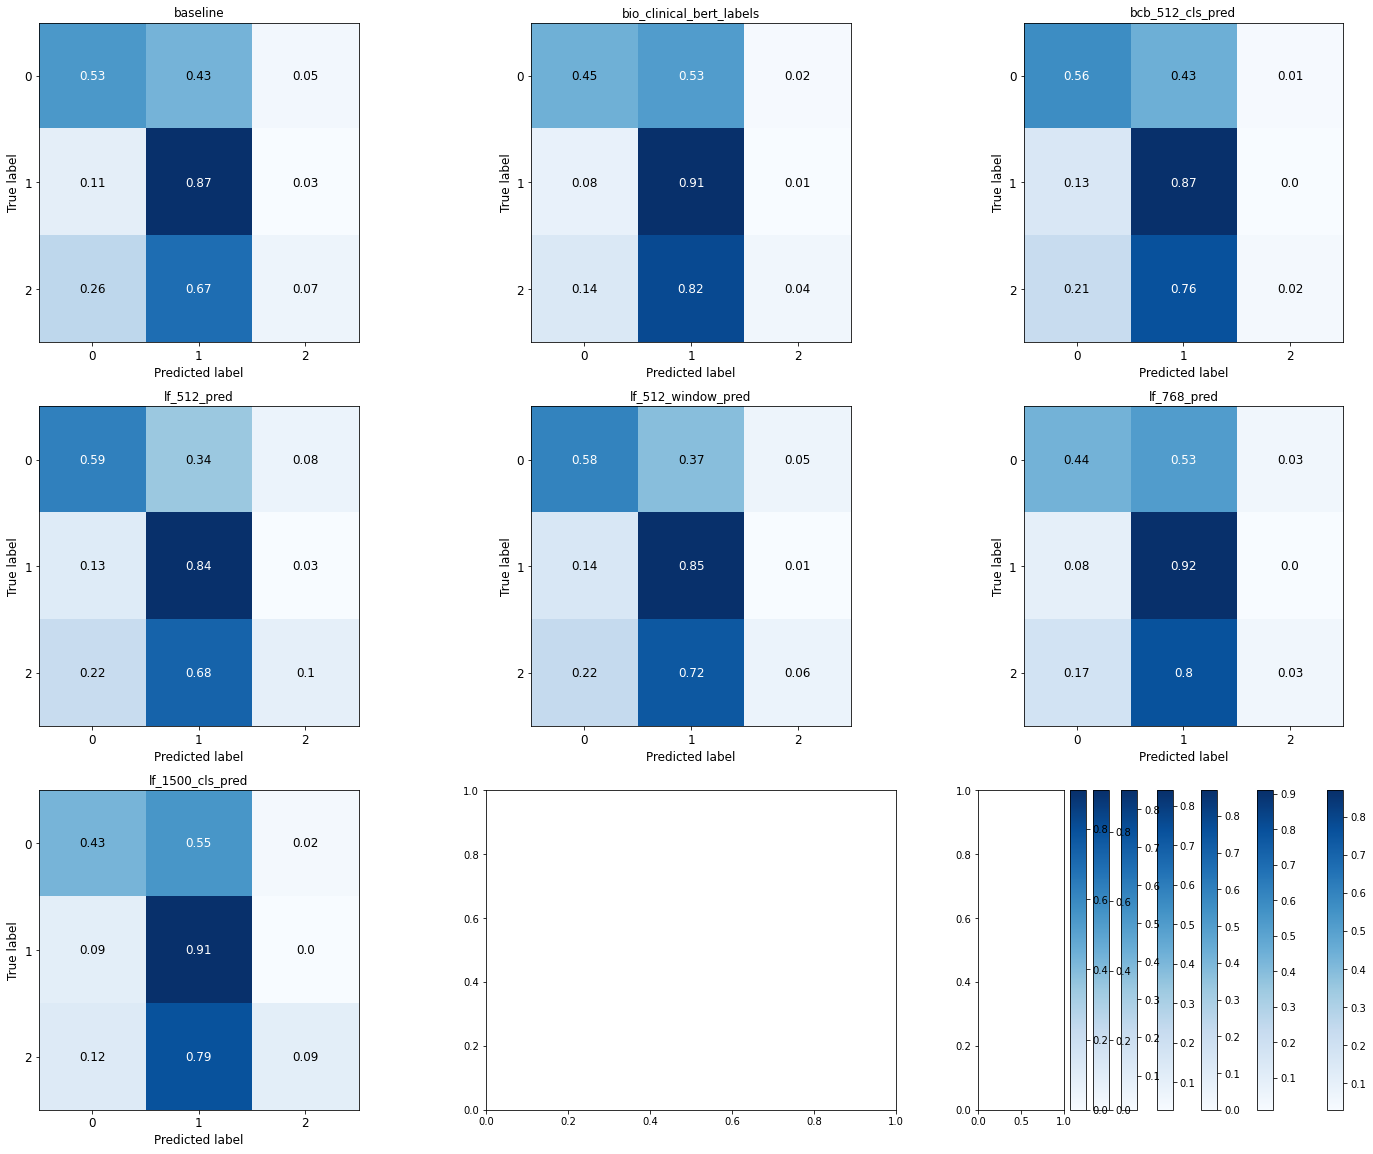

In [ ]:
def plot_conf_matrix_distance(x, y, models):
    
    print()

    fig, ax = plt.subplots(3, 3, figsize=(25,20))

    for i, model in enumerate(models):
        if i < 3:
            skplt.metrics.plot_confusion_matrix(
                results['labels'][(results['distance']>x) & (results['distance']<y)], 
                results[model][(results['distance']>x) & (results['distance']<y)],
                normalize=True,
                figsize=(5,5),
                title=model,
                title_fontsize='large',
                text_fontsize='large',
                ax=ax[0,i])
        elif i < 6:
            skplt.metrics.plot_confusion_matrix(
                results['labels'][(results['distance']>x) & (results['distance']<y)], 
                results[model][(results['distance']>x) & (results['distance']<y)],
                normalize=True,
                figsize=(5,5),
                title=model,
                title_fontsize='large',
                text_fontsize='large',
                ax=ax[1,i-3])
            
        elif i < 9:
            skplt.metrics.plot_confusion_matrix(
                results['labels'][(results['distance']>x) & (results['distance']<y)], 
                results[model][(results['distance']>x) & (results['distance']<y)],
                normalize=True,
                figsize=(5,5),
                title=model,
                title_fontsize='large',
                text_fontsize='large',
                ax=ax[2,i-6])

    
plot_conf_matrix_distance(0, 16, models)

Model has challenges predicting class 0 in all distances.

Model performs class 1 prediction well for shorter distances.

Model performs class 2 prediction well for longer distances.

# Data Distribution

(0.0, 6500.0)

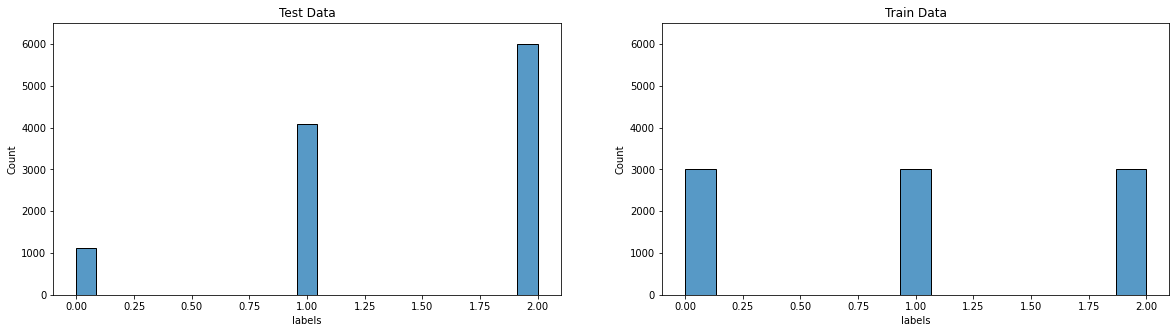

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))
sns.histplot(ax=ax[0], data=results, x='labels')
sns.histplot(ax=ax[1], data=resample, x='labels')
ax[0].set_title('Test Data')
ax[1].set_title('Train Data')

ax[0].set_ylim(0, 6500)
ax[1].set_ylim(0, 6500)

The model was trained a resampled (with replacement) of the full train dataset, such that there is an even number of examples for each class.

Though trained on the resampled dataset, the model was tasked to predict on the natural distribution of the test data.

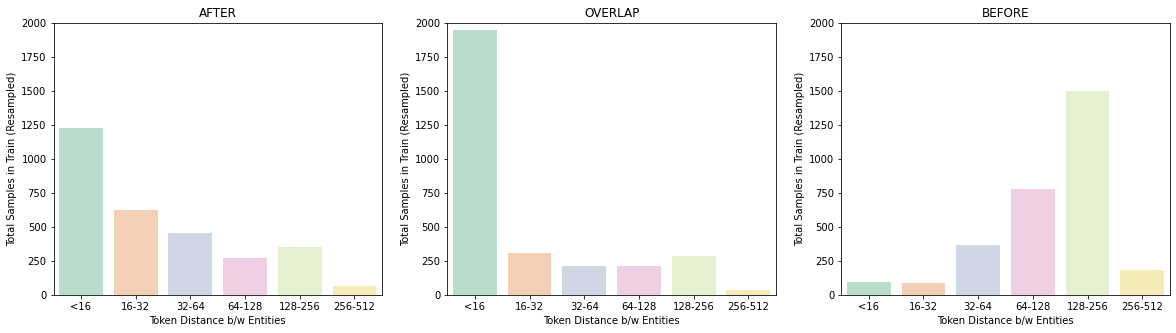

In [ ]:
# Train data
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

for i in range(0, 3):
    temp = resample[resample['labels']==i]['distance']
    title = ['AFTER', 'OVERLAP', 'BEFORE']

    buckets = ['<16', '16-32', '32-64', '64-128', '128-256', '256-512']
    bucket_dist = [
    np.sum(temp < 16) ,              
    np.sum((temp >= 16) & (temp < 32)),
    np.sum((temp >= 32) & (temp < 64)),
    np.sum((temp >= 64) & (temp < 128)),
    np.sum((temp >= 128) & (temp < 256)),
    np.sum((temp >= 256) & (temp < 512))]

    sns.barplot(ax=ax[i], x=buckets, y=bucket_dist, palette='Pastel2')
    ax[i].set_title(title[i])
    ax[i].set_xlabel('Token Distance b/w Entities')
    ax[i].set_ylabel('Total Samples in Train (Resampled)')
    ax[i].set_ylim(0, 2000)

Both the test and train data have similar distributions.  We also notice that the distribution is different amongst classes.  Class 2 has a higher fraction of long distance entity pairs.  Whereas Class 0 and Class 1 have a higher fraction of short distance entity pairs.

# Performance vs Distance

The performance has a direct relationship on each class is proportional to the number of examples at each distance.  

Labels 0 and 1 perform well at shorter distances and label 2 performs well with long distances.

Therefore, not only should we resample for labels, we need to balance distances as well.  Unfortunately with such a small dataset, it makes it difficult.

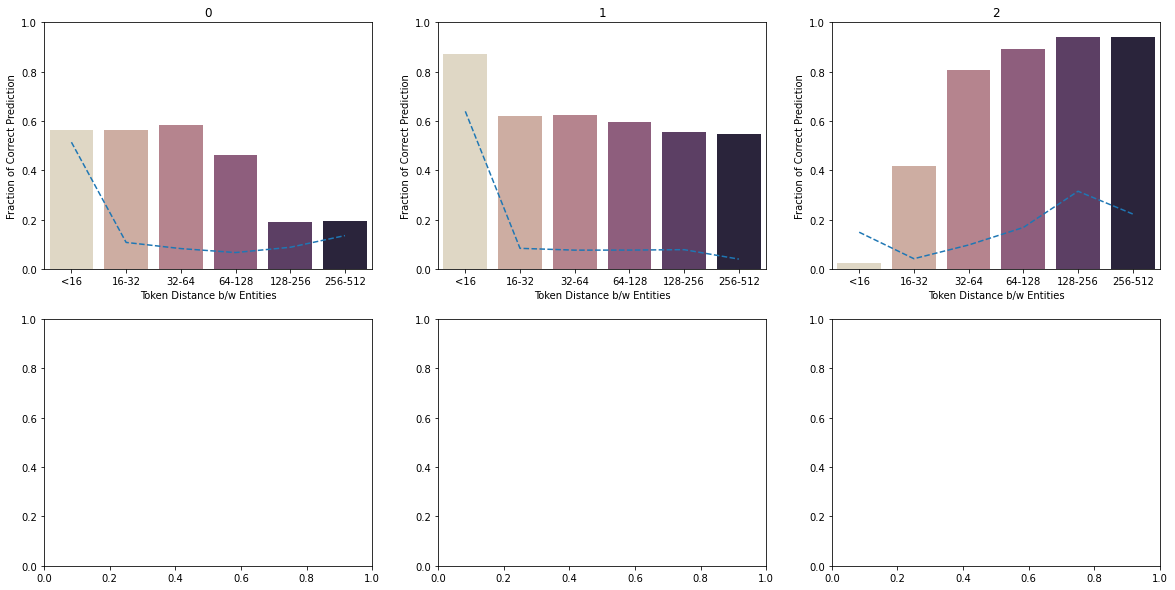

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(20, 10))

def correct_vs_distance(model):
    # Add correct to column
    results['correct'] = results['labels'] == results[model]

    for i in range(0, 3):
        # Distribution of test data
        temp = results[results['labels']==i]['distance']

        buckets = ['<16', '16-32', '32-64', '64-128', '128-256', '256-512']
        bucket_dist = [
        np.sum(temp < 16)/len(temp) ,              
        np.sum((temp >= 16) & (temp < 32))/len(temp),
        np.sum((temp >= 32) & (temp < 64))/len(temp),
        np.sum((temp >= 64) & (temp < 128))/len(temp),
        np.sum((temp >= 128) & (temp < 256))/len(temp),
        np.sum((temp >= 256) & (temp < 512))/len(temp)]

        sns.lineplot(ax=ax[0,i], x=buckets, y=bucket_dist, linestyle="dashed")
        ax[0,i].set_title(i)
        ax[0,i].set_xlabel('Token Distance b/w Entities')
        ax[0,i].set_ylabel('Fraction of Correct Prediction')

        # Distribution of correct answers
        temp = results[results['labels']==i][['distance', 'correct']]

        buckets = ['<16', '16-32', '32-64', '64-128', '128-256', '256-512']
        bucket_dist = [
        np.sum(temp[temp['distance'] < 16]['correct'])/len(temp[temp['distance'] < 16]['correct']),
        np.sum(temp[(temp['distance'] >= 16) & (temp['distance'] < 32)]['correct'])/
            len(temp[(temp['distance'] >= 16) & (temp['distance'] < 32)]['correct']),
        np.sum(temp[(temp['distance'] >= 32) & (temp['distance'] < 64)]['correct'])/
            len(temp[(temp['distance'] >= 32) & (temp['distance'] < 64)]['correct']),
        np.sum(temp[(temp['distance'] >= 64) & (temp['distance'] < 128)]['correct'])/
            len(temp[(temp['distance'] >= 64) & (temp['distance'] < 128)]['correct']),
        np.sum(temp[(temp['distance'] >= 128) & (temp['distance'] > 256)]['correct'])/
            len(temp[(temp['distance'] >= 128) & (temp['distance'] > 256)]['correct']),
        np.sum(temp[(temp['distance'] >= 256) & (temp['distance'] < 512)]['correct'])/
            len(temp[(temp['distance'] >= 256) & (temp['distance'] < 512)]['correct'])
            ]

        sns.barplot(ax=ax[0,i], x=buckets, y=bucket_dist, palette='ch:s=-.2,r=.6')
        ax[0,i].set_title(i)
        ax[0,i].set_xlabel('Token Distance b/w Entities')
        ax[0,i].set_ylabel('Fraction of Correct Prediction')
        ax[0,i].set_ylim(0, 1)

correct_vs_distance(models[1]) 

The data distribution matches the prediction distribution for class 1 and 2.  This may suggest more examples are needed for certain distances between entities to improve model.

The distribution of the predictions are similar between BioClinical BERT and Longformer.  This is expected since both model architectures are similar.  Surprisingly, the pretraining of BioClinical BERT on medical text did not produce higher performance in comparison to Longformer.

# Specific Examples of Misclassification

In [ ]:
def get_example(i, d1, d2, label, correct, model):
    if correct == False:
        temp = results[(results['labels'] == label) & (results['labels'] != results[model])]
        temp = temp[(temp['distance'] > d1) & (temp['distance'] < d2)].reset_index()
        print('example: ', temp['ID'][i])
        print('distance: ', temp['distance'][i])
        print('(actual, predict): ', (temp['labels'][i], temp[model][i]))
        print()
        return temp['Text'].tolist()[i]
    elif correct == True:
        temp = results[(results['labels'] == label) & (results['labels'] == results[model])]
        temp = temp[(temp['distance'] > d1) & (temp['distance'] < d2)].reset_index()
        print('example: ', temp['ID'][i])
        print('distance: ', temp['distance'][i])
        print('(actual, predict): ', (temp['labels'][i], temp[model][i]))
        print()
        return temp['Text'].tolist()[i]

Class 0

In [ ]:
get_example(10, 256, 512, 0, False, models[5])

example:  222_SECTIME7
distance:  333
(actual, predict):  (0, 2)



'Admission Date : [R] 2012-03-23 [R] Discharge Date : 2012-03-26 Service : MEDICINE History of Present Illness : 39 year old male w/ h/o low back pain on chronic narcotics presents after being found unresponsive at home . His daughter awoke him at 7 a.m. , reports he said he felt " cold and shivery ," vomited several times , then drove her to school . According to his wife , he came home and went to sleep . When she tried to awaken him at 11 a.m. , she was unable to do so and called EMS . She did not notice any blood / urine / emesis / stool in the bed . EMS found him with agonal respirations and pinpoint pupils . FS 420 . He received 1 mg IV Narcan ( numerous bottles of oxycontin , percocet were found in room ); his pupils dilated to ~ 8 mm and he became combative / agitated . He was then intubated for airway protection ( etomidate / succinate ); it was a traumatic intubation  and one of his teeth was chipped . He was transported to Hallmark Health System Monica , where ABG 7.14/82/44

In [ ]:
get_example(2, 256, 512, 0, True, models[5])

example:  442_TL49
distance:  272
(actual, predict):  (0, 0)



"Admission Date : 2017-05-14 Discharge Date : 2017-06-26 Service : CMED CCU HISTORY OF PRESENT ILLNESS : Jadiara Harrison is twin #1 [R] born [R] to a 17 year-old primiparous mother at 31 weeks gestation . Mother was admitted to the Nantucket Cottage Hospital from Lawrence General Hospital Hospital on 05-01 with cervical effacement and preterm labor . She was treated with magnesium sulfate . She had previously been admitted here at the 24th week after a motor vehicle accident .She was treated with tocolysis and betamethasone at that time . Due to progressing labor and presentation of twins , delivery was by Cesarean section . Prenatal screens were notable for blood type 0 positive , antibody negative , hepatitis B surface antigen negative , RPR nonreactive . Rubella status was not documented . Group B strep status was unknown . Infant emerged from the breech position . She was vigorous . She was given blow-by oxygen and stimulation . Her Apgars were 7 at 1 minute and 9 at 5 minutes . S